In [2]:
import gensim
import os
from distutils.version import LooseVersion, StrictVersion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import re

In [3]:
from gensim.models import Word2Vec

In [4]:
modelwv = Word2Vec.load("W2Vmodel.bin")

In [4]:
# print(modelwv.wv['việt_nam'])

In [5]:
# modelwv.wv.most_similar('việt_nam', topn=5)

In [5]:
len(modelwv.wv)

137183

In [8]:
data_train = pd.read_csv('train_data.csv')
data_val = pd.read_csv('val_data.csv')
data_test = pd.read_csv('test_data.csv')
data_train_val = pd.concat([data_train,data_val])

In [9]:
data_train_val

,Unnamed: 0.1,Unnamed: 0,text,lable,word_length
0,8478,9164,doanh_nghiệp giải tiên_phong cộng_đồng sanofi ...,Doisong,456
1,13771,15421,nasa_hủy phóng sứ_mệnh mặt_trăng artemis cơ_qu...,Khoahoc,282
2,7852,8485,tại_sao hoa trái_cây khoa_học giải_thích hoa t...,Doisong,150
3,36984,41054,pháp kêu_gọi eu xét_nghiệm covid trung_quốc ph...,Thegioi,254
4,39410,43546,pakistan chặn cao_tốc đốt xe cựu thủ_tướng bắt...,Thegioi,213
...,...,...,...,...,...
8917,60,64,làng_nghề đan mê bồ dòng sông tiền đồng thápmê...,Chinhtrixahoi,562
8918,4529,4872,không_khí lạnh tràn miền bắc không_khí lạnh tr...,Chinhtrixahoi,127
8919,11456,12643,đỗ hải_yến tri_ân điện_ảnh tp hcmđỗ hải_yến êk...,Giaitri,304
8920,2379,2539,bão mulan hướng quảng_ninh nam định chiều bão ...,Chinhtrixahoi,260


In [10]:
len(modelwv.wv)

137183

In [11]:
vocab=list(modelwv.wv.index_to_key)

In [12]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=modelwv.wv[word]
print("The no of key-value pairs : ",len(word_vec_dict))

The no of key-value pairs :  137183


In [13]:
maxi=-1
for i,rev in enumerate(data_train_val['text']):
    tokens=rev.split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
print(maxi)

1488


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
lable_types = ('Chinhtrixahoi','Doisong','Khoahoc','Kinhdoanh','Phapluat','Suckhoe','Thegioi','Thethao','Giaitri','Sohoa')
lable_df = pd.DataFrame(lable_types, columns=['lable'])
labelencoder = LabelEncoder()
data_train['new_lable'] = labelencoder.fit_transform(data_train['lable'])
data_val['new_lable'] = labelencoder.fit_transform(data_val['lable'])
data_test['new_lable'] = labelencoder.fit_transform(data_test['lable'])

In [29]:
import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split,cross_validate
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence

In [30]:
tok = Tokenizer()
tok.fit_on_texts(data_train_val['text'])
vocab_size = len(tok.word_index) + 1


In [31]:
encd_rev_train = tok.texts_to_sequences(data_train['text'])
encd_rev_val = tok.texts_to_sequences(data_val['text'])
encd_rev_test = tok.texts_to_sequences(data_test['text'])

In [32]:
max_rev_len=400  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

In [33]:
vocab_size

77849

In [34]:
pad_rev_train= pad_sequences(encd_rev_train, maxlen=max_rev_len, padding='post')
pad_rev_val= pad_sequences(encd_rev_val, maxlen=max_rev_len, padding='post')
pad_rev_test= pad_sequences(encd_rev_test, maxlen=max_rev_len, padding='post')


In [35]:
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:
    embed_matrix[i]=embed_vector

In [36]:
y_train=keras.utils.to_categorical(data_train['new_lable'],num_classes=10)
y_val=keras.utils.to_categorical(data_val['new_lable'],num_classes=10)
Y_test=keras.utils.to_categorical(data_test['new_lable'],num_classes=10)

In [37]:
x_train = pad_rev_train
x_val = pad_rev_val
x_test = pad_rev_test

In [38]:
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional,SpatialDropout1D

In [39]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
model.add(SpatialDropout1D(0.5))
model.add(Bidirectional(LSTM(128, input_shape=(max_rev_len, ))))
model.add(Dense(10, activation='softmax'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 300)          23354700  
                                                                 
 spatial_dropout1d (SpatialD  (None, 400, 300)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
Total params: 23,796,566
Trainable params: 23,796,566
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [42]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [43]:
epochs=10
batch_size=64

In [44]:
from keras.callbacks import EarlyStopping

In [45]:
history=model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val,y_val))

Epoch 1/10
419/419 [==============================] - 1671s 4s/step - loss: 1.1238 - accuracy: 0.6322 - val_loss: 0.6593 - val_accuracy: 0.7874
Epoch 2/10
419/419 [==============================] - 1279s 3s/step - loss: 0.6684 - accuracy: 0.7847 - val_loss: 0.5461 - val_accuracy: 0.8275
Epoch 3/10
419/419 [==============================] - 1280s 3s/step - loss: 0.5430 - accuracy: 0.8243 - val_loss: 0.4776 - val_accuracy: 0.8542
Epoch 4/10
419/419 [==============================] - 1291s 3s/step - loss: 0.4593 - accuracy: 0.8519 - val_loss: 0.4856 - val_accuracy: 0.8476
Epoch 5/10
419/419 [==============================] - 1553s 4s/step - loss: 0.4144 - accuracy: 0.8617 - val_loss: 0.4288 - val_accuracy: 0.8695
Epoch 6/10
419/419 [==============================] - 1609s 4s/step - loss: 0.3641 - accuracy: 0.8776 - val_loss: 0.4090 - val_accuracy: 0.8719
Epoch 7/10
419/419 [==============================] - 1578s 4s/step - loss: 0.3216 - accuracy: 0.8917 - val_loss: 0.4066 - val_accuracy:

In [1]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

NameError: name 'model' is not defined

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [47]:
y_hat = model.predict(x_test)
y_pred = np.argmax(y_hat, axis=1)
y_test_label =  np.argmax(Y_test, axis=1)

279/279 [==============================] - 192s 672ms/step


In [48]:
accuracy = accuracy_score(y_test_label, y_pred)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(y_test_label, y_pred, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(y_test_label, y_pred, average='macro')
print('Recall: %f' % recall)

Accuracy: 0.871778
Precision: 0.870109
Recall: 0.873029


In [37]:
b='Xây cầu vượt phá Tam Giang hơn 1.000 tỷ đồng , Dự án cầu vượt phá Tam Giang với tổng mức đầu tư hơn 1.000 tỷ đồng được HĐND tỉnh Thừa Thiên Huế thông qua, chiều 29/6. Cầu nối thị trấn Phú Đa với xã Vinh Xuân, huyện Phú Vang có chiều dài toàn tuyến khoảng 3km gồm: cầu qua phá Tam Giang dài khoảng 1,4km và đường dẫn hai đầu cầu dài khoảng 1,6km. Dự kiến dự án khởi công năm 2024 và hoàn thành sau bốn năm.Theo tờ trình của UBND tỉnh, dự án góp phần hoàn thiện mạng lưới giao thông chính trong khu vực, tạo động lực phát triển kinh tế xã hội huyện Phú Vang và các xã ven biển. Hiện từ TP. Huế và thị trấn Phú Đa đi các xã ven biển huyện Phú Vang theo hai hướng tỉnh lộ 10D - tỉnh lộ 18 (qua cầu Trường Hà) và tỉnh lộ 10A - quốc lộ 49A qua cầu Thuận An. Tuy nhiên, tuyến đường hai hướng này nhỏ hẹp, qua khu vực đông dân cư. Việc kết nối giao thông hai bờ Đông - Tây phá Tam Giang không thuận lợi, hiện chỉ có hướng di chuyển qua cầu Trường Hà, ảnh hưởng đến phát triển kinh tế xã hội trong khu vực, đặc biệt là phát triển du lịch biển, đầm phá.Riêng các xã ven biển như Vinh Xuân, Phú Diên... đi đến UBND huyện Phú Vang khoảng 15km, trong khi đó theo đường thẳng qua phá Tam Giang chỉ khoảng 3km.Hệ đầm phá Tam Giang – Cầu Hai trải dài 68 km đi qua huyện Phong Điền, Quảng Điền, TP Huế, huyện Phú Vang và huyện Phú Lộc. Đây là hệ đầm phá nước lợ lớn nhất khu vực Đông Nam Á với hệ sinh thái thủy sản phong phú.Toàn tỉnh Thừa Thiên Huế hiện có 5 cây cầu bắc qua phá Tam Giang - Cầu Hai gồm cầu Tam Giang, cầu Thuận An, cầu Trường Hà, cầu Đại Lộc và cầu Tư Hiền'

In [38]:
import gensim
from pyvi import ViTokenizer, ViPosTagger
a = ['Hai cầu nối Khu đô thị mới Thủ Thiêm có tên mới','Địa danh Ba Son và Thủ Thiêm được đặt tên cho hai cầu vượt sông Sài Gòn nối trung tâm thành phố với Khu đô thị Thủ Thiêm, sáng 14/6.',
'Cầu Thủ Thiêm 2 kết nối đường Tôn Đức Thắng (quận 1) đến khu đô thị mới được đặt tên Ba Son. Đây là công trình biểu tượng của TP HCM, khánh thành hồi tháng 4 năm ngoái với tổng vốn gần 3.100 tỷ đồng - kinh phí lớn nhất trong các cầu tại thành phố tính đến nay. Cầu dài gần 1,5 km, 6 làn xe, thiết kế dây văng với trụ tháp chính nghiêng về Thủ Thiêm, tạo điểm nhấn kiến trúc nổi bật trên sông Sài Gòn.','Còn cầu Thủ Thiêm 1 nối đường Ngô Tất Tố, Nguyễn Hữu Cảnh (quận Bình Thạnh) đến tuyến Nguyễn Cơ Thạch trong Khu đô thị Thủ Thiêm, được đổi tên lại thành Thủ Thiêm. Công trình này đã đưa vào khai thác từ năm 2008 với chiều dài hơn 1,2 km, 6 làn xe, tổng kinh phí đầu tư hơn 1.000 tỷ đồng.','Tên mới của hai cầu được HĐND TP HCM thông qua hồi tháng 12 năm ngoái. Theo Sở Văn hoá và Thể thao, Thủ Thiêm là tên gọi xuất hiện từ thế kỷ 18, đến nay địa danh này thuộc TP Thủ Đức. Thủ là đồn canh dưới thời phong kiến và cũng chỉ chức vụ đứng đầu một tổ chức hay đơn vị hành chính. Có thể người chỉ huy đồn binh tên Thêm nên dân gian quen gọi thành Thủ Thiêm.','Còn Ba Son là tên gọi từ năm 1790 khi chúa Nguyễn Ánh đặt trại thủy quân và xây dựng "xưởng thủy" bên bờ sông Sài Gòn. Ba Son được xem là cái nôi của ngành công nghiệp đóng và sửa chữa tàu thuỷ Việt Nam. Nơi đây trở thành phần quan trọng trong lịch sử đấu tranh giành độc lập dân tộc của Sài Gòn - TP HCM, gắn liền cuộc đời hoạt động của Chủ tịch Tôn Đức Thắng.','Phó chủ tịch UBND thành phố Dương Anh Đức cho biết việc sử dụng các tên gọi này cho hai cầu có ý nghĩa giáo dục truyền thống lịch sử, tạo sức hút thu hút đầu tư để thành phố sớm hoàn thành mục tiêu xây dựng Khu đô thị mới Thủ Thiêm. Các đơn vị liên quan cần làm tốt duy tu, bảo trì để hai công trình trở thành điểm nhấn cảnh quan đô thị của thành phố.','Theo quy hoạch, có 4 cây cầu và một hầm kết nối Khu đô thị mới Thủ Thiêm với trung tâm thành phố. Ngoài cầu Thủ Thiêm và Ba Son, hầm vượt sông Sài Gòn trên đại lộ Đông Tây nối quận 1 với khu đô thị này đã đưa vào khai thác cách đây 12 năm. Hai cầu còn lại gồm Thủ Thiêm 3 (nối quận 4) và Thủ Thiêm 4 (nối quận 7) chưa được đầu tư.']
text = []
for i in a:
    lines = gensim.utils.simple_preprocess(i)
    lines = ' '.join(lines)
    lines = ViTokenizer.tokenize(lines)
    text.append(lines)
text1 = ' '.join(text)
encd_rev1 = tok.texts_to_sequences(text1)
padded = pad_sequences(encd_rev1, maxlen=400)
pred = model.predict(padded)
#labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment'] 
labels = ['Chinhtrixahoi','Doisong','Giaitri','Khoahoc','Kinhdoanh','Phapluat','So hoa','Suckhoe','Thegioi','Thethao']
print(pred)
print(np.argmax(pred))
print(labels[np.argmax(pred)])

68/68 [==============================] - 42s 619ms/step
[[0.06637856 0.0119971  0.00337463 ... 0.01719722 0.37677568 0.4468723 ]
 [0.06637856 0.0119971  0.00337463 ... 0.01719722 0.37677568 0.4468723 ]
 [0.06637856 0.0119971  0.00337463 ... 0.01719722 0.37677568 0.4468723 ]
 ...
 [0.06637857 0.01199711 0.00337464 ... 0.01719723 0.37677583 0.44687214]
 [0.06868286 0.01186414 0.00337397 ... 0.01689547 0.36146274 0.45674196]
 [0.06637857 0.01199711 0.00337464 ... 0.01719723 0.37677583 0.44687214]]
4359


IndexError: list index out of range

In [ ]:
pred.shape

(2159, 10)

In [41]:
from matplotlib import pyplot as plt

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


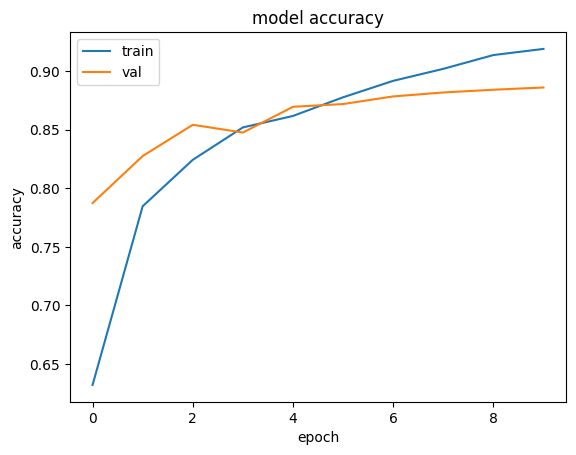

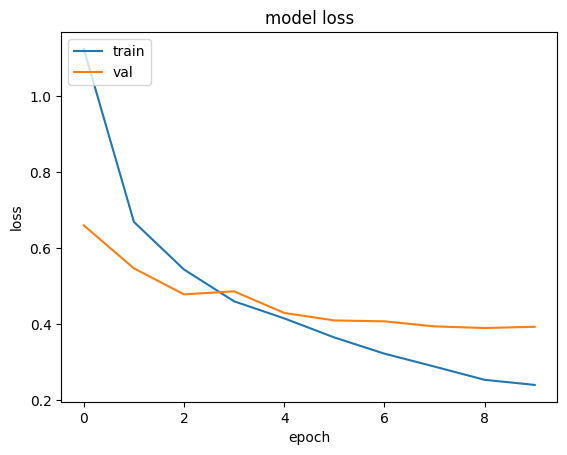

In [49]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save("model_lstm.h5")

In [ ]:
from keras.models import load_model

model123 = load_model('lstm.h5')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 31: invalid continuation byte

In [ ]:
from keras.models import load_model

In [ ]:
model.evaluate(x_test,y_test)